In [155]:
from utilities import *
import audio_features_utils
import threading
from sklearn.metrics import confusion_matrix

# SET CONSTANT

In [2]:
DATA_DIR_PATH = '../dataset/vctk/VCTK-Corpus/wav48/'
N_MFCC = 40
SR = 16000
AUDIO_LENGTH = 3 # seconds

# PREPARATION

In [122]:
def filename2path(fname):
    return DATA_DIR_PATH+fname[:4]+'/'+fname
def load_audio_and_resample(path):
    rate, audio = wavfile.read(path)
    audio = audio.astype(float)
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=-1)
    audio = librosa.core.resample(audio, rate, SR)
    return audio

def preprocess(audio, st='random'):
    assert st =='random' or type(st) == range, 'range has to be \'random\' or type range'
    length = int(SR*AUDIO_LENGTH)
    if len(audio) < length:
        temp = np.zeros((length,))
        temp[:len(audio)] = audio
        audio = temp
    elif st =='random':
        start_idx = np.random.randint(0, len(audio) - length)
        audio = audio[start_idx: start_idx+length]
    else:
        audio = audio[st: st+length] 
        
    return librosa.feature.mfcc(audio, sr=SR, n_mfcc=N_MFCC)

In [4]:
speakers = os.listdir(DATA_DIR_PATH)
speaker_to_label = dict()
for speaker in speakers:
    speaker_to_label[speaker] = len(speaker_to_label)

In [5]:
TEST_SIZE = 0.2
VAL_SIZE = 0.1
RANDOM_SEED = 99

In [6]:
data = pd.DataFrame(columns=['filename','label','mode'])
counts = dict()
for speaker in speakers:
    fnames = os.listdir(DATA_DIR_PATH+speaker)
    counts[speaker] = len(fnames)
    train, test = train_test_split(fnames, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    train, val = train_test_split(train, test_size=VAL_SIZE, random_state=RANDOM_SEED)
    
    temp = pd.DataFrame(np.transpose([
        train, 
        [speaker_to_label[speaker]]*len(train), 
        ['train']*len(train),
    ]),columns=['filename', 'label','mode'])
        
    data = data.append(temp, ignore_index=True)
    
    temp = pd.DataFrame(np.transpose([
        test, 
        [speaker_to_label[speaker]]*len(test), 
        ['test']*len(test)
    ]),columns=['filename', 'label','mode'])
        
    data = data.append(temp, ignore_index=True)
    
    temp = pd.DataFrame(np.transpose([
        val, 
        [speaker_to_label[speaker]]*len(val), 
        ['val']*len(val)
    ]),columns=['filename', 'label','mode'])
        
    data = data.append(temp, ignore_index=True)

In [26]:
speaker_idxes = 0
audios = []
rates = []
mode = 'val'
for fname in data[(data['label']=='0')&(data['mode']==mode)]['filename']:
    rate, audio = wavfile.read(DATA_DIR_PATH+fname[:4]+'/'+fname)
    audios.append(librosa.core.resample(audio.astype(float), 48000, 16000))
    rates.append(rate)

In [27]:
mfccs = np.array([preprocess(audio) for audio in audios])

In [28]:
len(audios), len(rates), mfccs.shape

(19, 19, (19, 40, 94))

# SAMPLE

In [10]:
sample_audio = librosa.core.resample(audios[0].astype(float), 48000, 16000)
sample_mfcc = preprocess(sample_audio)

In [11]:
Audio(sample_audio, rate=16000)

In [12]:
data_shape = sample_mfcc.shape
data_shape

(40, 94)

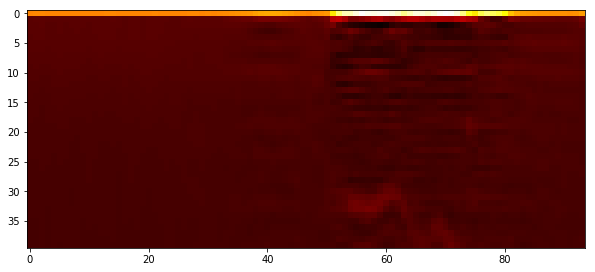

In [13]:
temp = preprocess(load_audio_and_resample(DATA_DIR_PATH+data['filename'][0][:4]+'/'+data['filename'][0]))
plt.figure(figsize=(10,10))
plt.imshow(temp, cmap='hot')

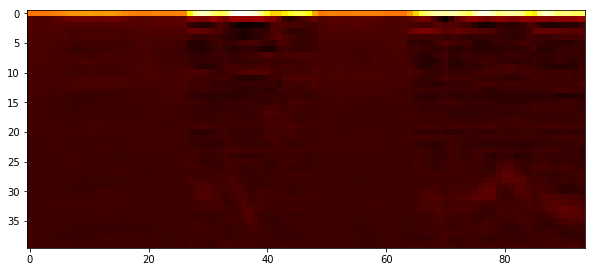

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(sample_mfcc, cmap='hot')

# MODEL

In [15]:
def feature_extractor13(name='feature_extractor', dup=0):
    def Conv(f, k, s, inp):
        inner = Conv1D(f, k, strides=s, padding='same')(inp)
        inner = BatchNormalization()(inner)
        inner = Activation(swish)(inner)
        return inner
        
    features = data_shape[0]
    input_layer = Input(data_shape, name='i1')
    inner = Lambda(lambda x: tf.transpose(x, [0,2,1]))(input_layer)
    inner = BatchNormalization(name='b1')(inner)
    
    features=64
    inner = Conv(features, 5, 2, inner)
    inner1 = Multiply()([gate(inner, 'sigmoid'), inner])
    inner = Conv1D(features, 7, padding='same')(inner)
    inner = Conv1D(features, 7, padding='same')(inner)
    inner = Multiply()([gate(inner, 'sigmoid'), inner])
    inner = Add()([inner1, inner])
    inner = BatchNormalization()(inner)
    inner = Activation(swish)(inner)
    
    inner1, inner2 = Lambda(lambda x: tf.split(x, 2, axis=-1))(inner)
    
    inner1 = Flatten()(inner1)
    inner1 = Dense(512)(inner1)
    
    inner2 = Flatten()(inner2)
    inner2 = Dense(512, activation='softmax')(inner2)
    
    inner = Multiply()([inner1, inner2])
    inner = BatchNormalization()(inner)
    output_layer = Dense(512, activation=swish)(inner)

    if not dup:
        return keras.models.Model(inputs=input_layer, outputs=output_layer, name=name)
    else:
        temp = []
        for i in range(dup+1):
            temp.append(keras.models.Model(inputs=input_layer, outputs=output_layer, name=name+'_'+str(i)))
        return temp

def full_model1():
    input_layer1 = Input(data_shape)
    fe = feature_extractor13()
    
    f1 = fe(input_layer1)
    f1 = Dropout(0.5)(f1)
    output_layer1 = Dense(len(speakers), activation='softmax', name='classifier')(f1)
    classifier = keras.models.Model(inputs=input_layer1, outputs=output_layer1, name='classifier')
    return classifier

# MODEL

In [16]:
model = full_model1()
model.summary()

W1017 12:51:21.506106 10848 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1017 12:51:21.522100 10848 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1017 12:51:21.584093 10848 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1017 12:51:21.602075 10848 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1017 12:51:22.266853 10848 deprecation.py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 94)            0         
_________________________________________________________________
feature_extractor (Model)    (None, 512)               1885152   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
classifier (Dense)           (None, 109)               55917     
Total params: 1,941,069
Trainable params: 1,939,709
Non-trainable params: 1,360
_________________________________________________________________


In [17]:
optimizer = keras.optimizers.Adam()

In [18]:
model.compile(optimizer, 'sparse_categorical_crossentropy', ['acc'])

W1017 12:51:22.340830 10848 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1017 12:51:22.347828 10848 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



In [19]:
model.load_weights('../models/vctkv2/01/weights-0.0141.hdf5')

# PREDICTION & EVALUATION

In [123]:
speaker_idxes = 0
audios = []
rates = []
mode = 'val'
labels = []
for fname in data[(data['label']==str(speaker_idxes))&(data['mode']==mode)]['filename']:
    audios.append(load_audio_and_resample(filename2path(fname)))
    rates.append(rate)
    labels.append(speaker_idxes)

In [125]:
mfccs = np.array([preprocess(audio) for audio in audios])

In [126]:
len(audios), len(rates), mfccs.shape

(19, 19, (19, 40, 94))

In [127]:
pred = model.predict(mfccs)

In [128]:
sparse_pred = np.argmax(pred, axis=-1)
sparse_pred

array([ 0,  0,  0,  0,  0,  0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0], dtype=int64)

In [133]:
model.evaluate(mfccs, labels)

19/19 [==============================] - 0s 263us/step


[0.19874148070812225, 0.9473684430122375]

# MULTIPLE PREDICTION & EVALUATION

In [166]:
speaker_idxes = list(range(109))
audios = []
rates = []
mode = 'val'
labels = []
for _,row in data[(data['label'].apply(int).isin(speaker_idxes))&(data['mode']==mode)].iterrows():
    fname = row['filename']
    audios.append(load_audio_and_resample(filename2path(fname)))
    rates.append(rate)
    labels.append(int(row['label']))
labels = np.array(labels)

In [167]:
mfccs = np.array([preprocess(audio) for audio in audios])

In [168]:
len(audios), len(rates), mfccs.shape

(3578, 3578, (3578, 40, 94))

In [169]:
pred = model.predict(mfccs)

In [170]:
sparse_pred = np.argmax(pred, axis=-1)

In [171]:
for i in speaker_idxes:
    print(sparse_pred[np.array(labels) == i])

[ 0  0  0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11]
[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12]
[13 13 13 13 13 13 13 13 13 13 13

[83 83 83 83 83 83 83 83 83 83 83 83 83 83]
[84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 67
 84 84 84 84 84 84 84 84 84 84]
[85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85]
[86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86
 86 86 86 86 86 86 86 86 86 86]
[87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87
 87 87 87 87 87 87 87 87 87 87]
[88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88
 88 88 88 88 88 88 88 88]
[89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89
 89 89 89 89 89 89 89 89 89 89]
[90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90
 90 90 90 90 90 90 90 90 90 90]
[91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91
 91 91 91 91 91 91 91 91 91 91]
[92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92]
[93 93 93 93 93 9

In [172]:
model.evaluate(mfccs, labels)

3578/3578 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 146us/step


[0.021195067942245367, 0.9944102850754611]

In [173]:
conf_matrix = confusion_matrix(labels, sparse_pred, labels=np.arange(109))

In [174]:
incorrect_matrix = conf_matrix.copy()
for i in range(incorrect_matrix.shape[0]):
    incorrect_matrix[i,i] = 0
# incorrect_matrix

1


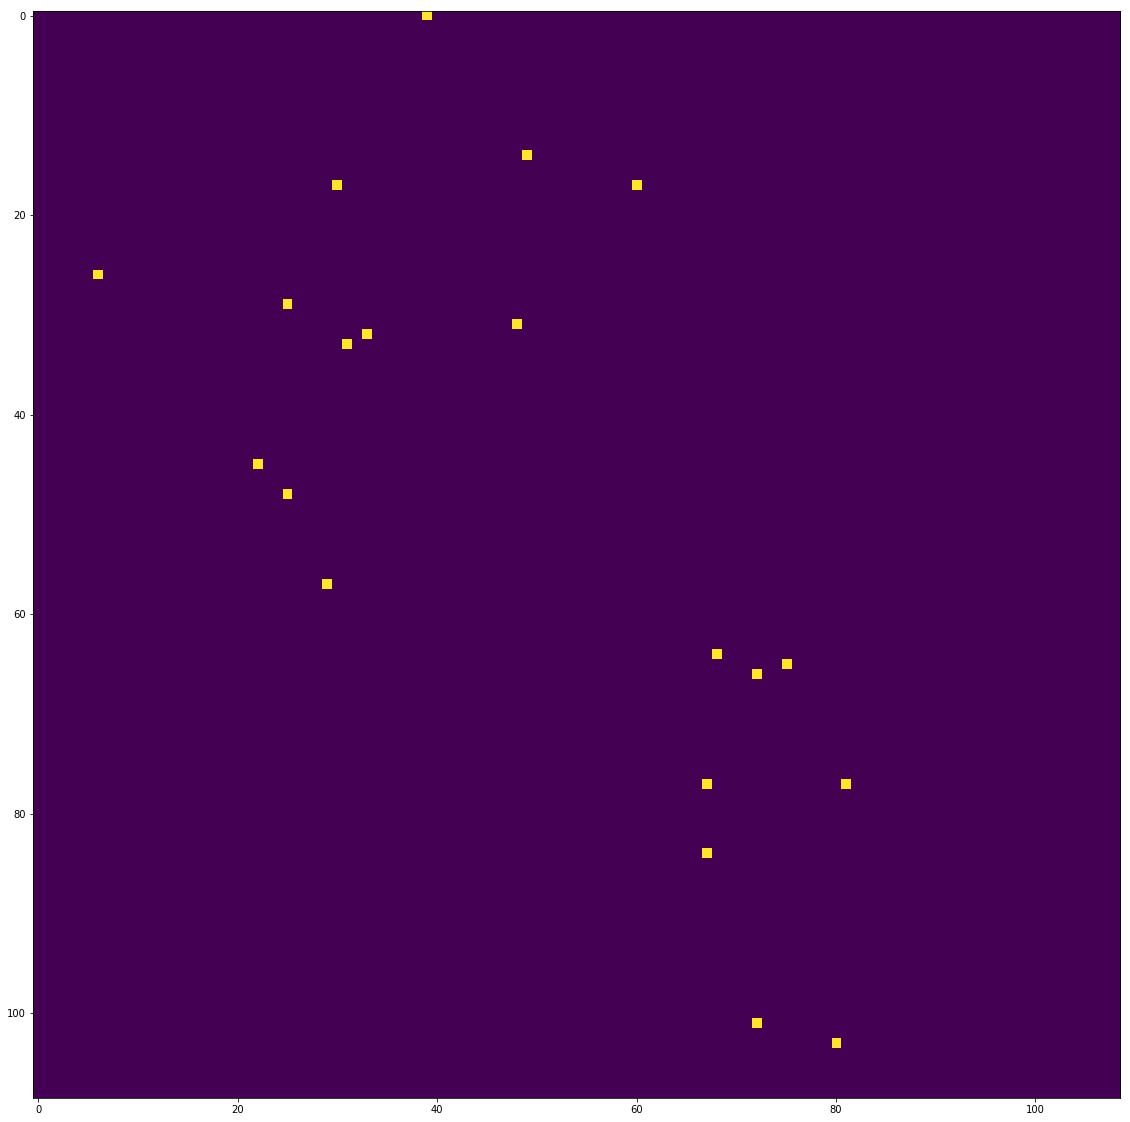

In [175]:
plt.figure(figsize=(20,20))
plt.imshow(incorrect_matrix)
print(incorrect_matrix.max())